In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import os
from glob import glob

from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from skimage import morphology

from dask import delayed
from dask import array as da
from dask.distributed import Client, progress

import napari

# TIF stack to stack of numpy arrays using Dask

This notebook takes a stack of `*.tif` files and then
1. Creates a dask array.
1. Asks the the user to view the file and pick the subset that cuts off most of the metacarpals
2. Computes a histogram.
3. Uses the histogram to estimate houndsfiend units.
4. Resets data type to include negatives and transformed to houndsfield units.
5. Saves as a stack of numpy arrays in the `hands` folder.

In [2]:
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='4GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.19.111.216:8787/status,
Dashboard: http://172.19.111.216:8787/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: False
Comm: inproc://172.19.111.216/7464/1,Workers: 0
Dashboard: http://172.19.111.216:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://172.19.111.216/7464/4,Total threads: 4
Dashboard: http://172.19.111.216:63944/status,Memory: 3.73 GiB
Nanny: None,


In [17]:
specific = "S232028"
input_dir = "../raw_data/" + specific + '/*.tif'
output_dir = "../hands/" + specific + '/'
os.makedirs(output_dir, exist_ok=True)

In [18]:
filenames = sorted(glob(input_dir), key=alphanumeric_key)
# read the first file to get the shape and dtype
# ASSUMES THAT ALL FILES SHARE THE SAME SHAPE/TYPE
sample = imread(filenames[0])

In [19]:
lazy_imread = delayed(imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(delayed_reader, shape=sample.shape, dtype=sample.dtype)
    for delayed_reader in lazy_arrays
]
# Stack into one large dask.array
ct_scan = da.stack(dask_arrays, axis=0)
ct_scan.shape  # (nfiles, nz, ny, nx)

spacing = np.array([0.07515304, 0.07513978, 0.075138  ])
np.save(f'../spacing/{specific}.npy', spacing)

In [20]:
ct_scan

dask.array<stack, shape=(2633, 1325, 1827), dtype=uint16, chunksize=(1, 1325, 1827), chunktype=numpy.ndarray>

### User input needed:

First, look at the file using the cell below

In [8]:
viewer = napari.Viewer()
ct_scan_view = viewer.add_image(
    ct_scan,
    scale=spacing,
)

Then, determine a good subset that only includes the fingers and part of the metacarpals, and use the next cell to compute the subset

In [21]:
newtype = np.promote_types(ct_scan.dtype, np.byte)
hand = ct_scan.astype(newtype)[1250:,:,:]

The cell below calculates the relative maxima of the histogram using an arbitrary limit to how close they can be.  In this case it is set to 50.  We then know that air will be the most common, and something close to soft tissue will be the second most common.  From [here](https://www.sciencedirect.com/topics/medicine-and-dentistry/hounsfield-scale#:~:text=Introduction%20to%20Ultrasound%2C%20CT%2C%20and%20MRI&text=The%20Hounsfield%20scale%20is%20a%20scale%20that%20is%20used%20to,;%20and%20air%2C%20%E2%88%921000.) we know that muscle and soft tissue will range from $20$ to $40$ and fat will range $-30$ to $-70$.  Since soft tissue is close enough to zero, we will assume it is for the rest of our calculations.

In [22]:
hist, bins = da.histogram(hand.ravel(), bins = 2**12, range=[0,2**16])
hist = hist.compute()

hist_centers = bins[:-1] + (bins[1]/2)
#Compute the relative maximum - in this case within 50.  50 was chosen arbitrarily.  This outputs the indices.
rel_max_i = sp.signal.argrelmax(hist, order=50)[0]
#Put these indices back into the histogram to figure out which are the top two
rel_maxes = np.array([hist[i] for i in rel_max_i]) #There is probably a more numpy way to do this
water_i, air_i = [rel_max_i[j] for j in rel_maxes.argsort()[-2:]]
#Our best estimate for water and air will be at the center of the histogram bins that are first and second most common:
water, air = [hist_centers[i] for i in [water_i, air_i]]
print(f'air: {air}, and water: {water}')

air: 21704.0, and water: 23048.0


In [25]:
#air = 20808
#water = 22216
air = 21704.0
water = 23048.0

Text(0.5, 1.0, 'histogram of gray values')

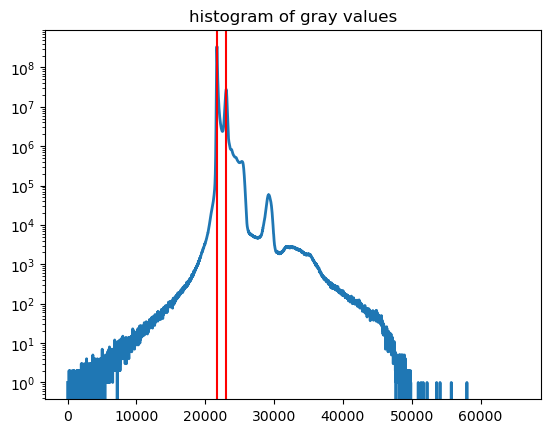

In [26]:
maxh = np.max(hist)
fig, axes = plt.subplots()
axes.plot(hist_centers, hist, lw=2)
axes.set_yscale('log')
axes.vlines([air,water], ymin = 0, ymax = maxh*4, color = 'red')
axes.set_title('histogram of gray values')

In some intances, like when a patient had a metal joint replacement, this method did not work

In [27]:
hand = (hand - water) // ((water-air) // 1000)

In [28]:
hand

dask.array<floordiv, shape=(1383, 1325, 1827), dtype=float64, chunksize=(1, 1325, 1827), chunktype=numpy.ndarray>

In [ ]:
da.to_npy_stack(output_dir, hand)

Optionally, you can view the file to make sure you saved the correct subset

In [18]:
hand = da.from_npy_stack(output_dir)

In [ ]:
viewer = napari.Viewer() 
viewer.add_image(hand)

Sometimes we get voxel spacing from a picture of Fred's computer:

In [19]:
xs = 132.0439/1757
ys = 100.3116/1335
zs = 195.9599/2608
print(f'x:{xs}, y:{ys}, z:{zs}')


x:0.07515304496300512, y:0.07513977528089888, z:0.07513799846625767


In [20]:
spacing = np.array([xs,ys,zs])
np.save('../spacing/' + specific + '.npy', spacing)